External Test Function
==

A function for checking primes. Primes have nothing to do with the current project, the idea is just to have an operation that takes a long time to execute for the sake of testing.

The function has to be kept in an external file, too. If not, trying to use it with multiprocessing in the notebook will cause the notebook to hang. I'm not sure why, but there is a discussion about it here:<br>
https://stackoverflow.com/questions/47313732/jupyter-notebook-never-finishes-processing-using-multiprocessing-python-3

In [35]:
import external

# Multiprocessing using Pools (Given)
A simple framework for assessing the impact of multiprocessing on runtime on a multi-core machine. 

In [36]:
import time
import math
import multiprocessing
from multiprocessing import Pool


def pool_process(f, data, pool_size):
    
    start_time = time.perf_counter()
    
    pool = Pool(processes=pool_size)
    result = pool.map(f, data)
    
    pool.close()
    pool.join()
    
    end_time = time.perf_counter()
    overall_time = end_time - start_time
    
    return overall_time
 

Primes and Progress
==

Some primes of varying length as input to the external test function.

In [37]:
primes = [
    1,
    11,
    127,
    1237,
    12347,
    123457,
    1234577,
    12345701,
    123456791,
    1234567891
]

def prime(n_digits):
    return primes[n_digits - 1]

A quick check that the time taken to check these primes increases roughly linearly with the value of the prime (and so exponentially with the number of digits).

This is expected - the check function just loops through numbers between 2 and the the prime to be checked searching for factors.

1  -  1.7000002117129043e-06 seconds
2  -  4.600000465870835e-06 seconds
3  -  1.3700000636163168e-05 seconds
4  -  0.00014000000010128133 seconds
5  -  0.0013485999988915864 seconds
6  -  0.013593300000138697 seconds
7  -  0.1544878000004246 seconds
8  -  1.5102358000003733 seconds
9  -  15.449814699999479 seconds


<AxesSubplot:title={'center':'Time to check prime'}, xlabel='number of digits', ylabel='time (seconds)'>

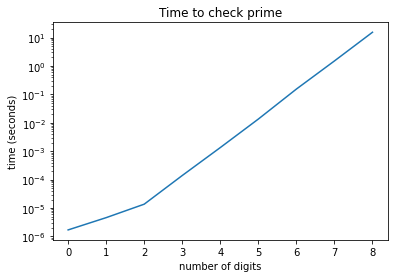

In [38]:
import pandas as pd

times = list()
for digits in range(1, 10):
    
    _, time_taken = external.check_prime(prime(digits))
    times.append(time_taken)
    
    print(digits, " - ", time_taken, "seconds")
    
pd.Series(times).plot(logy=True, title="Time to check prime", 
                      xlabel="number of digits", ylabel="time (seconds)")

As a quick aside, the cell below creates functions for displaying progress. I used this more in early iterations of the notebook, it isn't used that much any more though.

In [39]:
from IPython.display import display, Markdown, update_display

progress_title = None
progress_total = None

def progress_start(total, title = "Progress"):
    
    global progress_title, progress_total
    progress_title = title
    progress_total = total
    
    display(Markdown(title + ": 0%"), display_id=progress_title)
    
def progress_update(current):
    
    percentage = (100 * current) // progress_total
    message = f"{progress_title}: {percentage}%"
    
    update_display(Markdown(message), display_id=progress_title)

In [40]:
progress_start(1000)
for i in range(1000):
    progress_update(i + 1)

Progress: 100%

Initial Attempt at Timing
==

The direct approach. Plot how log it takes for a number of processes to complete a number of jobs of a certain size.

This cell takes quite a while to run with a default size of 9 digits, reducing that size parameter will decrease the time exponentially.

In [41]:
import pandas

size = 9

jobs = [
    [prime(size)], # One long job
    [prime(size - 1)] * 12, # A few medium jobs
    [prime(size - 3)] * 1300 # Lots of small jobs
]

n_processes = [1,2,3,4,5,6]

total_progress = len(jobs) * len(n_processes)
progress = 0
progress_start(total_progress)

results = list()
for job in jobs:

    results.append([])

    for n in n_processes:

        result = pool_process(external.check_prime, job, n)
        results[-1].append(result)

        progress += 1
        progress_update(progress)

Progress: 100%

The 1 long job takes varying amounts of times, but doesn't decrease with processes. This isn't surprising, since it cannot be split up.

Both the small and medium jobs show a good decrease with two processes over one, but diminishing returns for 3 & 4 processes. In fact, for 3 through to 6 processes it seems to be just fluctuating a bit, with any gains lost to noise.

<AxesSubplot:title={'center':'initial timings'}, xlabel='n processes', ylabel='time (seconds)'>

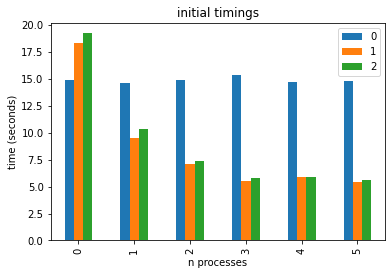

In [75]:
pd.DataFrame(results).T.plot(kind="bar", title="initial timings", xlabel="n processes", ylabel="time (seconds)")

Proportionate change from one process to two processes. Very close to twice as fast.

In [76]:
pd.DataFrame(results)[1] / pd.DataFrame(results)[0]

0    0.986207
1    0.518745
2    0.536872
dtype: float64

Proportionate change from two processes to three processes. I'd have hoped for at least 70% here, since 66% is the ideal limit.

In [77]:
pd.DataFrame(results)[2] / pd.DataFrame(results)[1]

0    1.015321
1    0.743871
2    0.717008
dtype: float64

Proportionate change from three processes to four processes

In [78]:
pd.DataFrame(results)[3] / pd.DataFrame(results)[2]

0    1.030788
1    0.780383
2    0.778011
dtype: float64

And finally from four to five.

In [38]:
pd.DataFrame(results)[4] / pd.DataFrame(results)[3]

0    0.982950
1    0.946098
2    1.022360
dtype: float64

As far as results go, we have the sanity check that multiprocessing has no effect on 1 job, and sigificant effect on multiple jobs. 

That being said, trying to interpret the above gets more difficult after that. 

My computer has 4 physical cores. When idling, as of writing this, it stays around 5-10% utilization with the occasional spike to 25%ish. From a naive POV this implies that it has at least 3 cores worth of free processing time to give.

With this in mind, for 12 medium jobs, I would expect a decrease by a factor of 3, roughly. The problem is almost fully parallizable, the 12 jobs can be split across 3 or 4 cores evenly. Each task takes the same amount of time to complete, roughly. (They are the same prime after all). So two cores working at two tasks should be twice as good as one core working at two tasks... ?

This does seem to hold almost true for the jump from one to two cores, with a 43% and 50% decrease in time taken for medium and small jobs respectively. After that, though, the percentage decrease in time per process to four processes is more like 10%, which is way less than expected. Even accounting for overhead in managing processes, that is confusing.

CPU Info
==

So far I've ignored the architecture of the CPU, beyond acknowledging that it is 4-core.

Taking a closer look at it, is an `Intel i7-8565U`. 
There is some very basic info here:<br>
https://ark.intel.com/content/www/us/en/ark/products/149091/intel-core-i7-8565u-processor-8m-cache-up-to-4-60-ghz.html

It just says 4 cores, no info on how those cores differ or if they do.<br>
It does point out that the turbo freq is 4.2 (GHz) to the base freq of 1.8! That is a huge difference. Using the CPUID HWMonitor tool, the variance in clock speed was evident - the computer shifted from 0.8 to 4.2 

It turns out the UEFI settings on my laptop allow disabling both turbo and dynamic changing of the frequency. A look at the output of the HWMonitor program confirms that the max is set to about 1.8. However, the minimum setting didn't seem to take - the processor still varies between about 0.8 and 1.8. 

In [ ]:
import pandas

size = 9

jobs = [
    [prime(size)], # One long job
    [prime(size - 1)] * 12, # A few medium jobs
    [prime(size - 3)] * 1300 # Lots of small jobs
]


n_processes = [1,2,3,4,5,6]

total_progress = len(jobs) * len(n_processes)
progress = 0
progress_start(total_progress)

results = list()
for job in jobs:

    results.append([])

    for n in n_processes:

        result = pool_process(miscFunc.check_prime, job, n)
        results[-1].append(result)

        progress += 1
        progress_update(progress)

Right. Well, disabling turbo boost did wonders for the fan noise, but it did not help with the strong fall off in performance gain. The graphs are almost identical.

<AxesSubplot:title={'center':'initial timings (no turbo)'}, xlabel='n processes', ylabel='time (seconds)'>

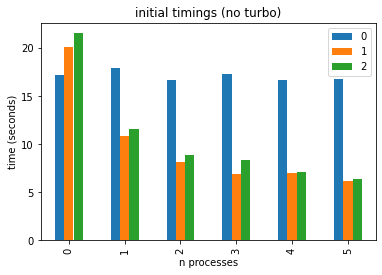

In [13]:
pd.DataFrame(results).T.plot(kind="bar", title="initial timings (no turbo)", xlabel="n processes", ylabel="time (seconds)")

Timelines and CPU Cores
==

I wasn't sure where to go from here. I know other students had similar graphs, and later saw that they matched the example charts given too, so that's reassuring. Explaining them is another story.

One thing that really appealed to me was a timeline graph by fellow student Adam McCarthy - he plotted segments along horizontal bar charts describing the precise sequence in which tasks were executes. I thought I might try something similar, but actually ended up going down a very different path - looking at which CPU a process is on with time.

It took some digging to find that python supports handy access to C win32 libraries, which allows the script below to ask windows directly for the current processor.

One thing I couldn't figure out how to do is link logical processors to physical processors. In the end, I thought it was simplest to disable hyperthreading. The CPU used here has 4 physical cores, **hyperthreading was disabled**.



In [17]:
import ctypes

results = list()
for i in range(1000000):
    results.append(ctypes.cdll.kernel32.GetCurrentProcessorNumber())

The results of this, plotted, are fascinating. It turns out that even one lone process doing one simple thing will end up bouncing between all four cores at a very fast rate.

This is something I should have expected, given our OS lectures last semester. The computer has a hundred different things to do and wishes to do these in real time - the only approach to this is to swap between lots of different things quickly. And since the amount of time a thread will spend in the core varies based on priorities and IO operations and such, there is no reason to think that when it finally swings back to being our process's turn to go back on the core, that the same core will be the latest one to become available. 

After a few days of having it in the back of my mind, I'm actually a bit surprised it seems to stay stable for extended periods of time. Perhaps the OS sometimes dedicates only some cores to real time concerns for a while, and lets others stay focused on longer tasks?

<AxesSubplot:title={'center':'what processor am I on?'}, xlabel='iteration', ylabel='processor num'>

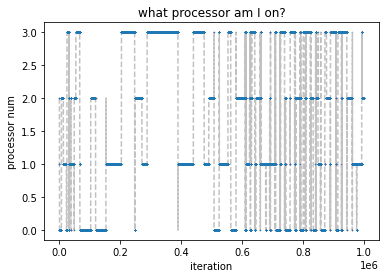

In [19]:
ax = pd.Series(results).plot(style="--", title="what processor am I on?", 
                        xlabel="iteration", ylabel="processor num",
                            alpha=0.3, color="#333")

pd.Series(results).plot(style=".", ms=0.05)

Note that in the graph above, blue dots represent points when the process was identified as being on a given processor. Gray lines connect the dots, and their frequency can be thought of as the frequency of transitions.

Right. This view of cores is interesting. The next step is to see how multiple processes look across multiple cores. To link the above with the pool stuff.

Since there are multiple tasks, a common time needs to be kept as index. To reduce as much as possible the amount of fancy python stuff going on, I attempted to reduce the task of recording a time and processor core to the relevant function calls and two array accesses. I have no idea if the micro-optimization had any effect beyond making indexing a headache in the code below.

Also note, the actual core loop needs to be in an external file again, since multiprocessing is being used. I've called the file "external.py"

In [2]:
import multiprocessing as mp
import external
import pandas as pd
import matplotlib.pyplot as plt

# WARNING: n_iterations requires a corresponding change in external.py, since it is
# hardcoded there.

# The "single_core" parameter is handled in external.py, by setting the
# cpu affinity for the current process. 
# (this is done in the process initialization callback given to the pool)

def record_raw(n_processes, n_tasks, n_iterations, single_core):

    # Collect the data in one long shared ctype array.
    
    raw_data = mp.Array('f', [-1.0] * (n_tasks * n_iterations * 2))
    indexes = [n_iterations * i * 2 for i in range(n_tasks)]   

    p = mp.Pool(processes = n_processes, initializer=external.init, initargs=(raw_data,single_core))
    p.map(external.track_core, indexes)

    return raw_data

The next step is to split out the messy array produced above into a neat pandas DataFrame. If there is a mistake in the code (and some of the results make me think there probably is), I imagine it might be here.

In [3]:
def record(n_processes = 4, n_tasks = 4, n_iterations = 10000, single_core = False):
    
    # Sort the data out into a friendly table.
    
    raw_data = record_raw(n_processes, n_tasks, n_iterations, single_core)
    
    data = list()

    for task_i in range(n_tasks):

        time_start = task_i * n_iterations * 2
        core_start = time_start + n_iterations

        for iteration_i in range(n_iterations):
            t = raw_data[time_start + iteration_i]
            core = raw_data[core_start + iteration_i]
            data.append([task_i, iteration_i, t, core])

    data = pd.DataFrame(data, columns = ["task", "iteration", "time", "core"])
    data.head(3)
    
    data.n_processes = n_processes
    data.n_tasks = n_tasks
    data.n_iterations = n_iterations
    
    return data

Finally, plot the data. 

All of these functions were simpler when I first wrote them, but as I discovered things I wished to explore I started adding parameters and such.

In [4]:
def plot_range(data, a = 0, b = None, ms = 0.25, tasks = None, offset=0):
    
    # a and b define the xlimits to plot. 
    # ms is the marker size.
    # a, b and ms together allow one to zoom in on a part of the plot.
    
    # "tasks" is a filter for which tasks to display the timeline for.
    
    # "offset" offsets the timeline for each task slightly, 
    # so that they can be viewed individually. 
    
    if b is None:
        b = data.n_iterations
    
    plt.figure(figsize=(15,5))
    plt.title("What core am I on?")
    plt.ylabel("Core")
    plt.xlabel("Time (seconds)")
    
    if tasks is None:
        tasks = range(data.n_tasks)
    
    for task_i in tasks:

        t = data[data.task == task_i].time[a:b]
        core = data[data.task == task_i].core[a:b]

        core -= task_i * offset
        
        plt.plot(t, core, ".", label=task_i, ms=ms)

The result is beautiful, I think. I've spent far too long staring at the graph below.

That being said, its veracity is extremely questionable, esp. since the same functions used to make it also make nonsensiscal graphs displayed in a later section.

Each group of coloured lines represents a cpu core. Each colour represents a task. Dots represent a point in time when a task was identified as being on a certain cpu.

Two things are immediately noticable. 

The first is that the tasks hop about like mad. The frequency of switching is much greater with multiple processes than it was with a single process. This suggests a potentially significant overhead in context switching, that may increase with the number of processes.

Early on, I thought maybe that it shouldn't make a difference, where context switching overhead is concerned, how many processes we have here, because windows already has lots of processes spinning around. That seems to be completely false, though, when comparing this graph to the single task & process one way above. It makes a huge difference to the behaviour. (Though it remains to be seen if that has a significant impact on time)

The second thing is that some cpus are used more than others. In particular, we seem to have 2 cpus very available, one sometimes available, and one not much available at all. This matches the original graph way back when showing the increase in performance for each core added - 2 cores was great, 3 much less, and 4 barely noticable. After staring at this graph for long enough, I became convinced that this might be a much larger effect than the context switching mentioned before. I wish I had a computer with 6 or 8 cores to play with in order to make more comparisons.

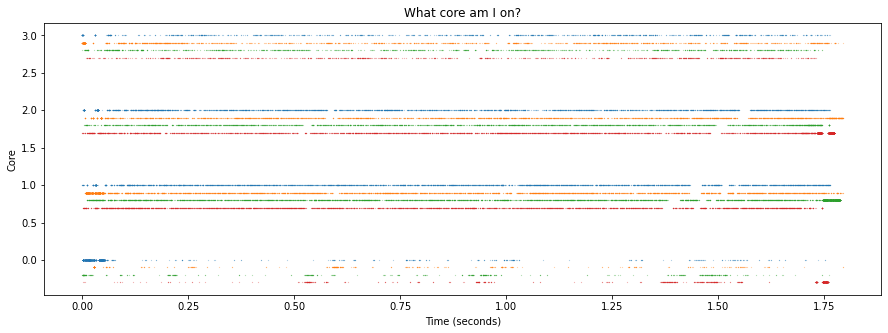

In [5]:
test = record(n_processes=4, n_tasks=4)
plot_range(test, offset=0.1)

One minor caveat before continuing I feel I must mention is that the accuracy of the above graph is probably not very high for individual dots. The graph zoomed in below shows closely overlapping dots. This seems to mean one of two things - either the time and processor number are out of sync, or the core can change fast enough that we can't be sure that the processor number and time aren't out of sync...

I thought it might be because there are too many instructions per iteration, or maybe because the clock isn't accurate enough.

It sounds bad, but overall, I don't think it matters. It's the shape of the graph that matters, realistically I could drop both axes and retain most of the info. And it makes intuitive sense to me that with large numbers of dots the shape would remain mostly intact.

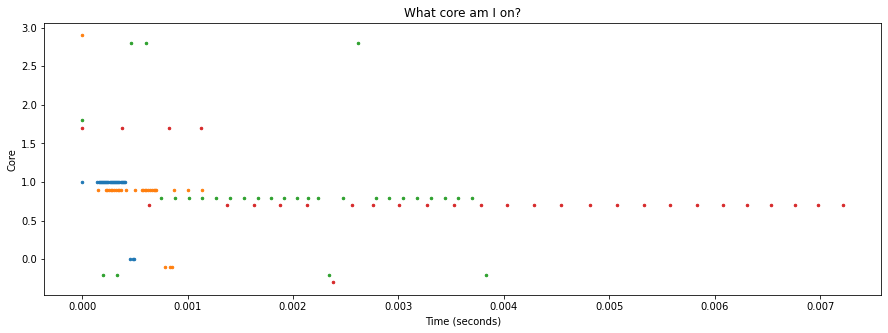

In [5]:
test = record(n_processes=4, n_tasks=4)
plot_range(test, a=0, b=30, ms=5, offset=0.1)

This next one is counter intuive, but note the offset and y axis limits. 

It shows that 4 processes on one core are executed in parallel, rather than in series. For our use case, this makes no sense and shows that splitting things up can slow things down. But then, the OS is just given tasks to schedule, it can only guess at the time they take and their relative importance.

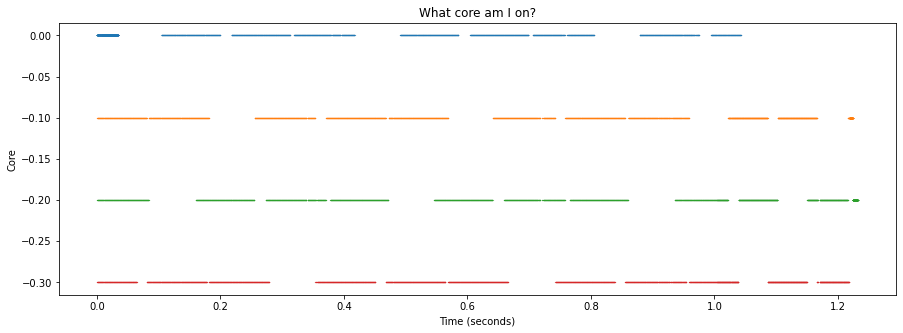

In [7]:
test = record(n_processes=4, n_tasks=4, single_core=True)
plot_range(test, offset=0.1)

This is on the same note as above - Each task finished around the same time. 

If they were run in series, we'd get the result for each but the last task much sooner.

<AxesSubplot:>

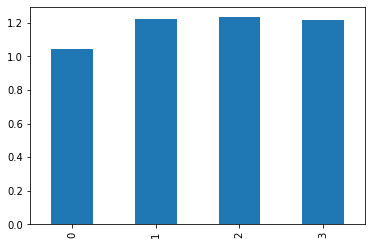

In [12]:
def get_task_times(data):
    
    timings = list()
    for task_i in range(data.n_tasks):
        task_data = data[data.task == task_i]
        start = task_data.time.min()
        end = task_data.time.max()
        timings.append(end - start)
    return pd.Series(timings)

get_task_times(test).plot(kind="bar")

Context Switches
==

Python is probably not the best environment to try and measure the performance hit of context switches in... at least not with my limited knowledge of how python works.

This section attempts this by looking at the distance between dots of the same color vs dots of different colors.

Surprisingly, consecutive dots of the same color have intervals of a nice distribution.

Unsurprisingly, consecutive dots of different color have intervals that make no sense at all. The measurement is in no way sensitive enoug for this kind of calculation.

In [114]:
core_0 = test[test.core == 0].sort_values(by="time")

intervals = list()
switches = list()

previous_task = -1
previous_time = 0
for i in range(len(core_0)):
    
    task = core_0.task[core_0.index[i]]
    t = core_0.time[core_0.index[i]]
    
    interval = t - previous_time
    previous_time = t
    
    different = previous_task != task
    previous_task = task
    
    if different:
        switches.append(interval)
    else:
        intervals.append(interval)
        
switches = pd.Series(switches)
intervals = pd.Series(intervals)

In [115]:
print(len(switches), len(intervals))

1198 1160


Intervals between consecutive dots of the same color are distributed nicely. I didn't look far into it, though, in light of how awful the next graph is. One might infer an average loop time of 170 microseconds with this.

<AxesSubplot:>

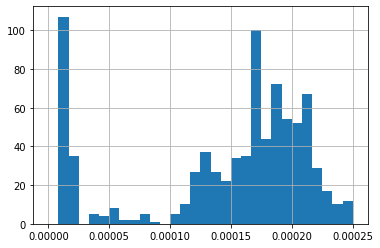

In [122]:
intervals.hist(range=(0, 0.00025), bins=30)

Unless I've made a mistake (highly possible) this is a nice bit of evidence towards context switching happening to quickly for the originally measurement method to track.

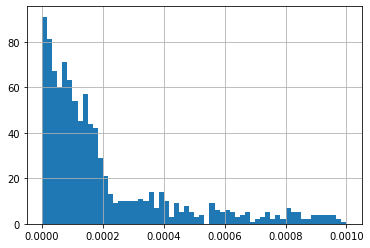

In [121]:
ax = switches.hist(range=(0, 0.001), bins=60)

(0.0, 20.0)

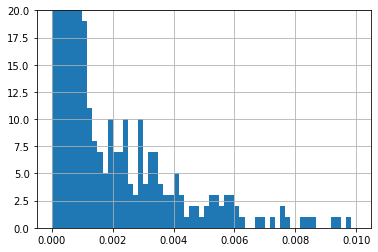

In [116]:
ax = switches.hist(range=(0, 0.01), bins=60)
ax.set_ylim(0, 20)

CPU Availability
==

One much, much easier and possibly more useful statistic that can be derived is the proportionate availability of the CPU.

This just involves counting dots.

In [165]:
counts = test.groupby("core").count()["task"]
counts

core
0.0     3679
1.0    16136
2.0    13292
3.0     6893
Name: task, dtype: int64

These proportions look eerily familar.

In [166]:
counts_p = list((counts / counts.max()).sort_values(ascending=False))
counts_p

[1.0, 0.823748140803173, 0.42718145761031234, 0.22799950421417947]

<AxesSubplot:>

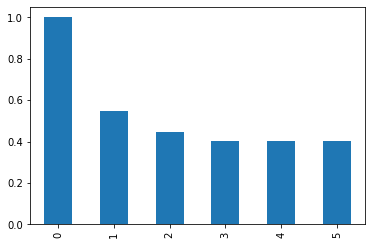

In [167]:
times = list()
for i in range(len(counts_p)):
    power = sum(counts_p[0:i+1])
    times.append(1/power)
    
# This is just to match the original plot where up to 6 jobs are considered
# (But since there are 4 cores the last two don't see any improvement)
times.append(times[-1])
times.append(times[-1])

pd.Series(times).plot(kind="bar")

A recap - the original paradox we're trying to explain.

In [169]:
import time
import multiprocessing as mp

def pool_process(f, data, pool_size):
    
    start_time = time.perf_counter()
    
    pool = mp.Pool(processes=pool_size)
    result = pool.map(f, data)
    
    pool.close()
    pool.join()
    
    end_time = time.perf_counter()
    overall_time = end_time - start_time
    
    return overall_time

job = [12345701] * 12 # A few medium jobs

n_processes = [1,2,3,4,5,6]

results = list()
for n in n_processes:
    result = pool_process(external.check_prime, job, n)
    results.append(result)

results = pd.Series(results)

In [170]:
results_p = results / results.max()
results_p

0    1.000000
1    0.469178
2    0.317832
3    0.301483
4    0.286672
5    0.274621
dtype: float64

I totally expected the theory to underestimate the overhead, but it seems to have overestimated it.

I'm guessing that I'm underestimating how slow the 4 process version is above. 

<AxesSubplot:>

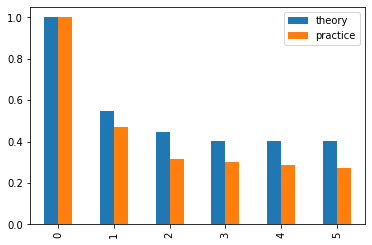

In [171]:
pd.DataFrame({
    "theory": times,
    "practice": results_p
}).plot(kind="bar")

Doom
==

I was fairly optimistic about the previous counting model, but after seeing the results below I realised that it might be time to stop.

Here, the core tracking tasks are run for different numbers of processes. 

The beautiful nonsensical thing is that there is an extreme drop in performance for three or more processes compared to two or less.

I could easily have made an error in the code above, though I have scrutinized it somewhat.

Boldly assuming I didn't, my best guess is that the kernel was running my system calls on it's own cores separate to the processes from the pool. With 2 processes, this is fine. With 3 or more, we effectively get something akin to thrashing and the frequency of swapping increases dramatically. But that is complete guesswork.

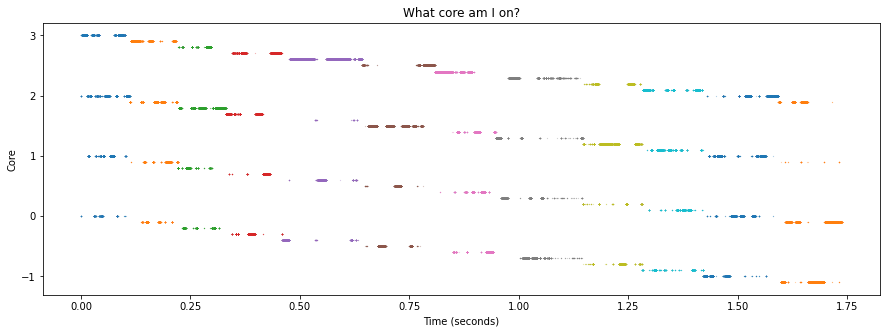

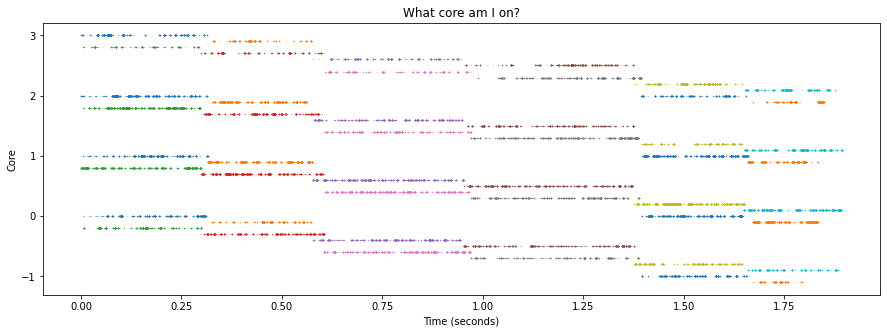

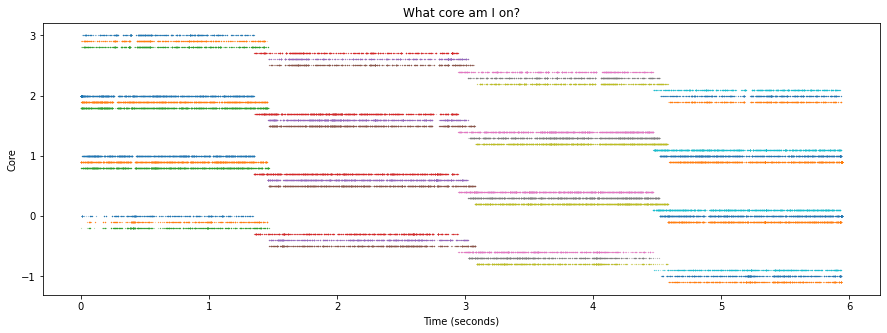

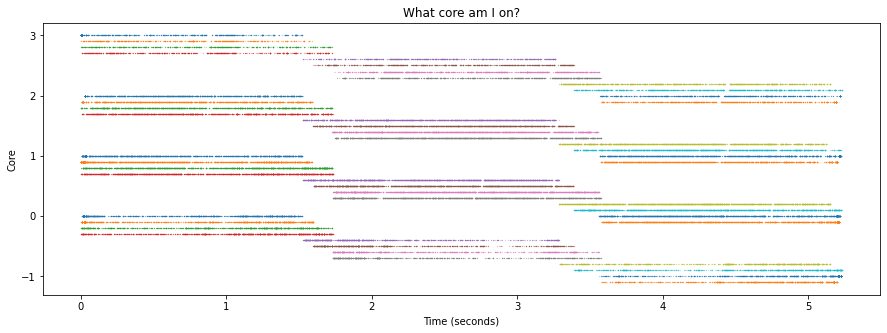

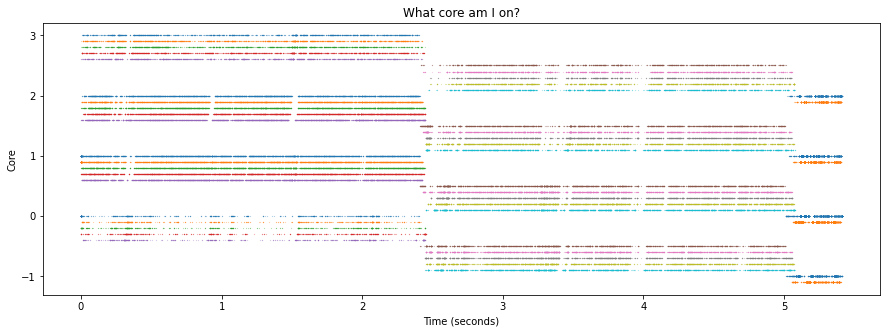

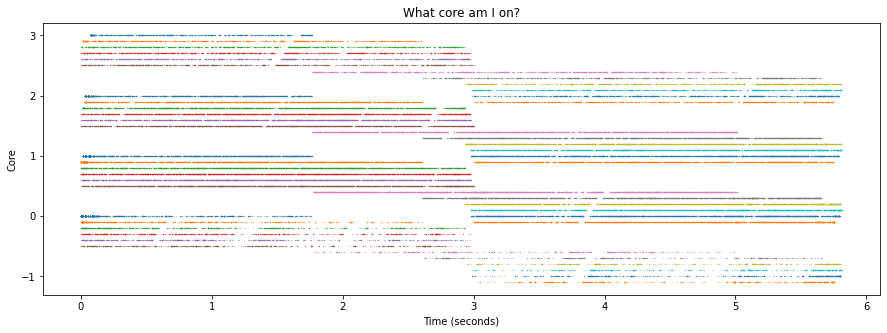

In [30]:
core_tracker_timings = list()
core_counts = list()

for i in range(1, 7):
    
    test = record(n_processes=i, n_tasks=12)
    
    plot_range(test, offset=0.1)
    
    start_time = test.time.min()
    end_time = test.time.max()
    
    core_tracker_timings.append(end_time - start_time)
    
    counts = list()
    for i in range(4):
        counts.append(test[test.core == i].count().core)
        
    counts = pd.Series(counts)
    counts = counts / counts.max()
    core_counts.append(counts)

<AxesSubplot:>

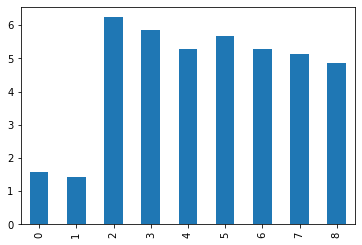

In [29]:
core_tracker_timings = pd.Series(core_tracker_timings)
core_tracker_timings.plot(kind="bar")

<AxesSubplot:>

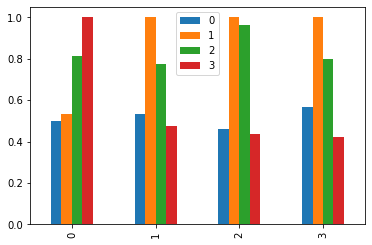

In [32]:
core_counts = pd.DataFrame(core_counts)
core_counts[core_counts.index < 4].plot(kind="bar")